## Example script for calculation of dose measured by LABDOS01

The following code demonstrates the method how to calculate radiation dose detected by silicon semiconductor based dosimeter LABDOS01B. The following proces expect the user is familiar with concept of [jupiter notebooks](https://jupyter.org/) and have a basic knowledge of [Python3](https://www.python.org/).

For demonstration we use an data recording contained in the LABDOS repository. The recording contains transatlantic travel between America and Europe. The recording should contains trip in both directions with one tranfer.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import matplotlib
import re

directory = './data/' # Directory with data 

FIRST_CHANNEL = 9 # a column of the 1st channel without noise
ZERO_CHANNEL = 5 # a column of the channel with maximal noise
CH_WIDTH = 0.013 # [MeV]

Because the detector produces multiple files to record data in sufficiently long files, there could be multiple text files, which wee need to concanetate along measurement runs. The recorded files has been anonymised therefore serial numbers here are displayed as `ffffffffffffffffffffffffffffffff` for valid LABDOS product, there should be an proper serial number of the device. 

In [2]:
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

df=pd.DataFrame()

files = sorted(glob.iglob(directory + '/*.TXT'), key=numericalSort)
for file in files:
    print(file)
    l=[]
    l.extend(range(0,520))
    f = pd.read_csv(file, sep=',', header=None, names=l, comment='*', low_memory=False)
    try:
        sn = f.loc[f[0]=='$DOS'].iloc[0,6]
        print("S.N.: ", sn)
    except:
        sn = 0
    df = pd.concat([df,f])

df = df.reset_index(drop=True)

./data/0.TXT
S.N.:  ffffffffffffffffffffffffffffffff
./data/1.TXT
S.N.:  ffffffffffffffffffffffffffffffff


As we can see there is in the example data two measurement runs.  We should display raw data from the each data to see its content.

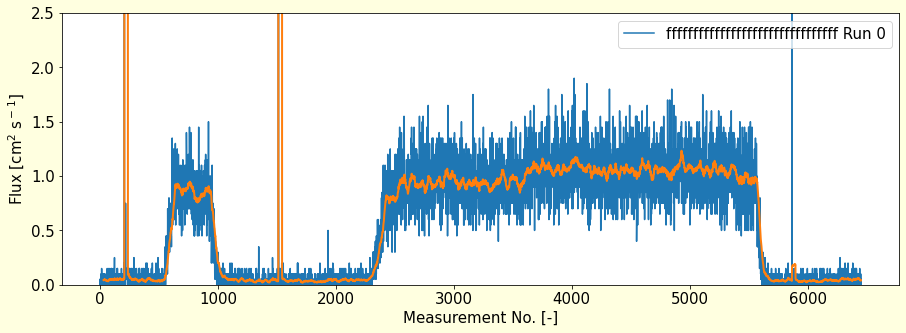

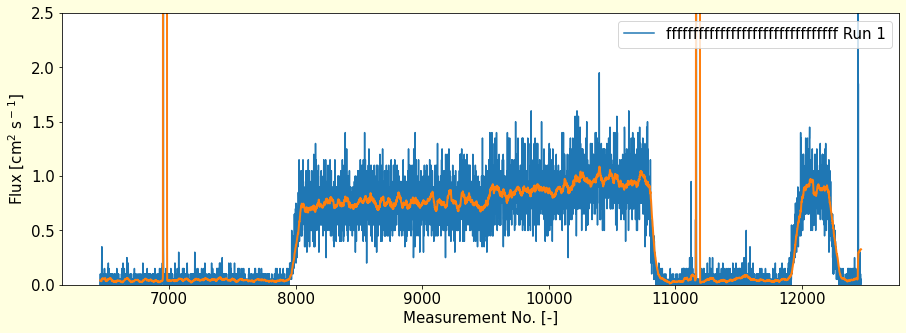

In [3]:
run = 0

df['run'] = np.nan

try:
    for x in df.loc[df[0]=='$DOS'].index:
        df.loc[x,'run'] = run
        run += 1
except:
    pass
df['run'].fillna(method="ffill", inplace=True)
df = df.loc[df[0]=='$HIST']

df['sum'] = df.iloc[:,FIRST_CHANNEL:520].sum(axis=1)
df['mean'] = df['sum'].rolling(30).mean()

matplotlib.rcParams.update({'font.size': 15})

for r in range(0,run):
    plt.figure(figsize=(15,5), facecolor='lightyellow')
    plt.plot(df.loc[df['run']==r]['sum']/20, label=sn+' Run '+str(r))
    plt.plot(df.loc[df['run']==r]['mean']/20, lw=2)
    plt.ylim(0,2.5)
    plt.xlabel('Measurement No. [-]')
    plt.ylabel('Flux [cm$^2$ s$^-$$^1$]')
    plt.legend(loc=1)
    plt.show()

As can be seen the each run consist two nicely separated flights. The short one, which corresponds to tranfer in the Europe and long transatlantic flight. 

Additionaly there are easily visible the X-ray events for luggage on airport security checks. 


Now lets plot somewhat processed data to see the phisicaly maaningfull variables like relative time instead of Measurement No. and dose rate according to accumulated energy spectra of absorbed ionization. 


0.065 0.013


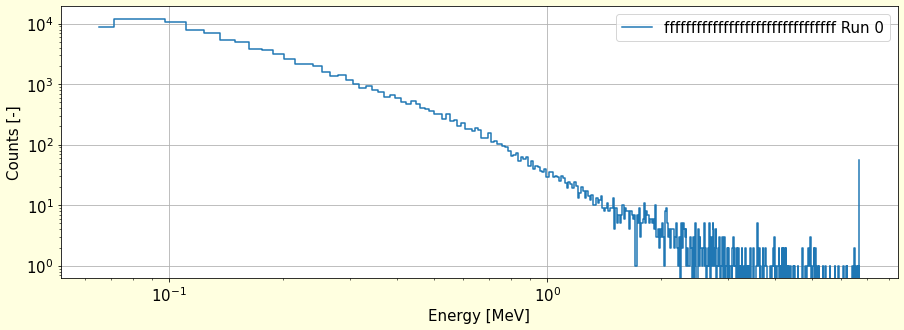

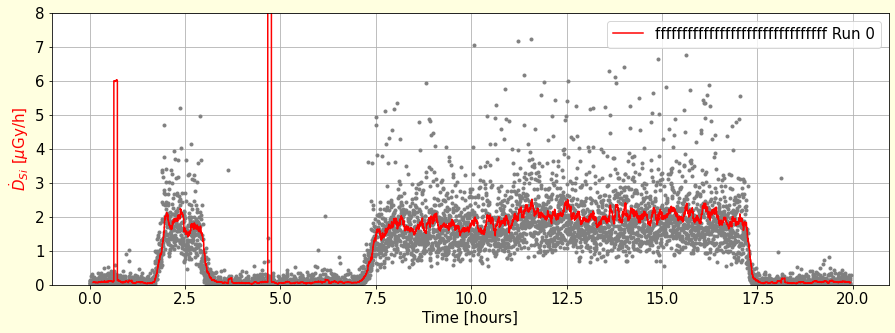

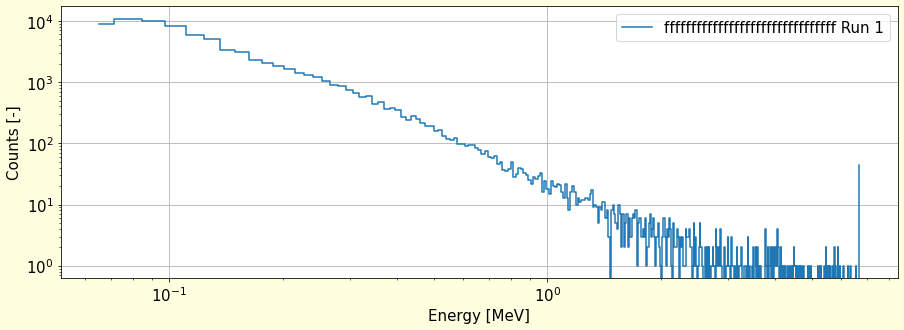

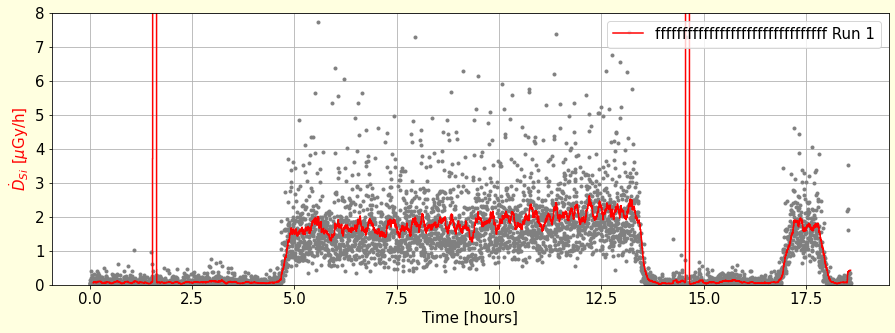

In [4]:
coef = np.array([0.,0.])
coef[1] = CH_WIDTH
coef[0] = CH_WIDTH*(FIRST_CHANNEL-ZERO_CHANNEL+1)
print(coef[0], coef[1])

for r in range(0,run):
    rc = df.loc[df['run']==r].copy()
    rc[2] = pd.to_numeric(rc[2], errors='coerce')

    plt.figure(figsize=(15,5), facecolor='lightyellow')
    matplotlib.rcParams.update({'font.size': 15})

    ener = rc.iloc[:,FIRST_CHANNEL:520].sum()
    
    e = pd.DataFrame()
    e['1'] = ener
    e['i'] = ener.index
    e['x'] = (e['i'].astype(float)-FIRST_CHANNEL) * coef[1] + coef[0]

    plt.plot(e['x'], e['1'], drawstyle='steps-mid', label=sn+' Run '+str(r))

    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Energy [MeV]')
    plt.ylabel('Counts [-]')
    plt.grid()

    plt.legend()
    plt.show()
    
    
    rc['ener'] = (np.asarray(rc.iloc[:,FIRST_CHANNEL:520]) * np.asarray(e['x'])).sum(axis=1)    
    
    # size of the chip (20 mm · 10 mm), 
    # the thickness of the depletion layer (0.3 mm), 
    # and the density of silicon (2.33 g cm^3)
    # 0.1165e-3 kg
    
    rc['dsi'] = ((1e6 * (1.602e-19 * rc['ener'] * 1e6)/0.1165e-3)/10) * 3600 # in uGy/h

    rc['dsimean'] = rc['dsi'].rolling(30).mean()

    plt.figure(figsize=(15,5), facecolor='lightyellow')
    matplotlib.rcParams.update({'font.size': 15})
    plt.plot(rc[2]/3600,rc['dsi'], c='gray', linestyle='', marker='.')
    plt.plot(rc[2]/3600,rc['dsimean'],c='red', drawstyle='steps-mid', label=sn+' Run '+str(r))

    plt.ylim([0,8])

    plt.xlabel('Time [hours]')
    plt.ylabel(r'$\.D$$_S$$_i$ [$\mu$Gy/h]', color='red')
    plt.legend(loc=1)

    plt.grid()
    plt.show()


Now the doserate and total dose in silicon coud be calculed from selected parts of data records.  The calculation interval should be selected according to flighs.

In [5]:
SELECTED_RUN = 0 # Measurement run (order of power on)
FROM = 7.0 # Start time in hour
TO = 18.0 # Stop time in hour


#SELECTED_RUN = 1 # Measurement run (order of power on)
#FROM = 4.0 # Start time in hour
#TO = 14.0 # Stop time in hour

Above code block contains predefined selections for the both transatlantic flights. The Europe to Americe is selected by default. The second one is commented out. 

In [6]:
coef = np.array([0.,0.])
coef[1] = CH_WIDTH
coef[0] = CH_WIDTH*(FIRST_CHANNEL-ZERO_CHANNEL+1)
print('Min. sensitivity', coef[0], '[Mev], Channel width', coef[1], '[MeV]')

df[2] = pd.to_numeric(df[2], errors='coerce')
rc = df.loc[df['run']==SELECTED_RUN].loc[df[2]>=FROM*3600].loc[df[2]<=TO*3600].copy()

ener = rc.iloc[:,FIRST_CHANNEL:520].sum()
e = pd.DataFrame()
e['1'] = ener
e['i'] = ener.index
e['x'] = (e['i'].astype(float)-FIRST_CHANNEL) * coef[1] + coef[0]
rc['ener'] = (np.asarray(rc.iloc[:,FIRST_CHANNEL:520]) * np.asarray(e['x'])).sum(axis=1)    

# size of the chip (20 mm · 10 mm), 
# the thickness of the depletion layer (0.3 mm), 
# and the density of silicon (2.33 g cm^3)
# 0.1165e-3 kg
rc['dsi'] = ((1e6 * (1.602e-19 * rc['ener'] * 1e6)/0.1165e-3)/10) * 3600 # in uGy/h

print('S.N.',sn)
print('Run '+str(SELECTED_RUN),' From', FROM, '[hour] to', TO, '[hour]')
mean_doserate = rc.loc[rc[2]>=FROM*3600].loc[rc[2]<=TO*3600]['dsi'].mean()
print('Mean Dose Rate\033[1m',round(mean_doserate,2),'\033[0m[μGy/h]')
print('Total dose in silicon\033[1m',round(mean_doserate * (TO-FROM),2),'±',3*round(rc.loc[rc[2]>=FROM*3600].loc[rc[2]<=TO*3600]['dsi'].sem(),2),'\033[0m[μGy]')

Min. sensitivity 0.065 [Mev], Channel width 0.013 [MeV]
S.N. ffffffffffffffffffffffffffffffff
Run 0  From 7.0 [hour] to 18.0 [hour]
Mean Dose Rate 1.74 [μGy/h]
Total dose in silicon 19.14 ± 0.06 [μGy]


As you can see the first transatlantic flight (excluding the local transfer in Europe) gives 19.14 ± 0.06 μGy to silicon. Method converting DSi to ambient dose equivalentH*(10) is still under scientific research and [this article](https://www.researchgate.net/publication/49709780_Use_of_energy_deposition_spectrometer_Liulin_for_individual_monitoring_of_aircrew) could be used as a reference. 